In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('city_clients.csv')

df[['fuel_gmv', 'fuel_avg_price', 'fuel_n_orders', 'supermarket_gmv',	'supermarket_avg_price',	'supermarket_n_orders',
    'afisha_gmv', 'afisha_avg_price', 'afisha_n_orders']] = df[['fuel_gmv', 'fuel_avg_price', 'fuel_n_orders', 'supermarket_gmv',
    'supermarket_avg_price',	'supermarket_n_orders', 'afisha_gmv', 'afisha_avg_price', 'afisha_n_orders']].fillna(0)

date_columns = ['fuel_first_order_date', 'supermarket_first_order_date', 'afisha_first_order_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.head()

,party_rk,gorod_client_flg,fuel_gmv,fuel_avg_price,fuel_n_orders,fuel_first_order_date,fuel_last_order_date,supermarket_gmv,supermarket_avg_price,supermarket_n_orders,...,kino_gmv,kino_transactions_cnt,arenda_avto_gmv,arenda_avto_transactions_cnt,knigi_gmv,knigi_transactions_cnt,zhivotnye_gmv,zhivotnye_transactions_cnt,turagentstva_gmv,turagentstva_transactions_cnt
0,1002611776,1,1499.06,749.530000,2.0,2023-05-22,2024-07-08,0.00,0.00,0.0,...,798.0,128.0,0.0,128.0,0.0,128.0,0.0,128.0,0.0,128.0
1,812910044,1,5600.68,1866.893333,3.0,2023-01-12,2024-03-30,0.00,0.00,0.0,...,0.0,92.0,0.0,92.0,0.0,92.0,0.0,92.0,0.0,92.0
2,379196768,1,32831.06,1492.320909,22.0,2023-08-12,2024-09-28,3775.76,1887.88,2.0,...,512.0,457.0,0.0,457.0,0.0,457.0,0.0,457.0,21680.0,457.0
3,695174271,1,0.00,0.000000,0.0,NaT,NaN,0.00,0.00,0.0,...,0.0,292.0,0.0,292.0,0.0,292.0,0.0,292.0,0.0,292.0
4,843828836,1,0.00,0.000000,0.0,NaT,NaN,1687.82,1687.82,1.0,...,0.0,528.0,0.0,528.0,0.0,528.0,0.0,528.0,0.0,528.0


Для начала исследуем конверсию в клиенты Города

In [ ]:
gorod_conversion = df['gorod_client_flg'].value_counts(normalize = True) * 100
gorod_conversion

,proportion
gorod_client_flg,
1,50.0
0,50.0


Ровно половина клиентов пользуется сервисами Города, а половина - нет.
Посмотрим, чем они отличаются друг от друга

In [ ]:
df.groupby('gorod_client_flg')['age'].mean()


,age
gorod_client_flg,
0,34.930411
1,36.262937


In [130]:
gorod_clients = df[df['gorod_client_flg'] == 1]
non_gorod_clients = df[df['gorod_client_flg'] == 0]

t_stat, p_value = sp.stats.ttest_ind(gorod_clients['age'], non_gorod_clients['age'], nan_policy='omit')
p_value

0.0


В среднем, клиенты города старше, чем не клиенты. Посмотрим, сколько мужчин и женщин среди клиентов города

In [164]:
gender_users =  df[df['gorod_client_flg'] == 1]['gender_cd'].value_counts(normalize = True) * 100
gender_users

,proportion
gender_cd,
M,58.953212
F,41.046788


Мужчин больше. Это может быть связано с популярностью сервиса 'Топливо' среди автовладельцев-мужчин. Теперь взглянем на зависимость конверсии в клиенты города от пола

In [ ]:
df.groupby('gender_cd')['gorod_client_flg'].mean() * 100

,gorod_client_flg
gender_cd,
F,45.858925
M,53.712448


Мужчины чаще начинают пользоваться Городом. Возможно, это всё так же связано с Топливом. Проверим эту гипотезу

/tmp/ipython-input-1929626376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0


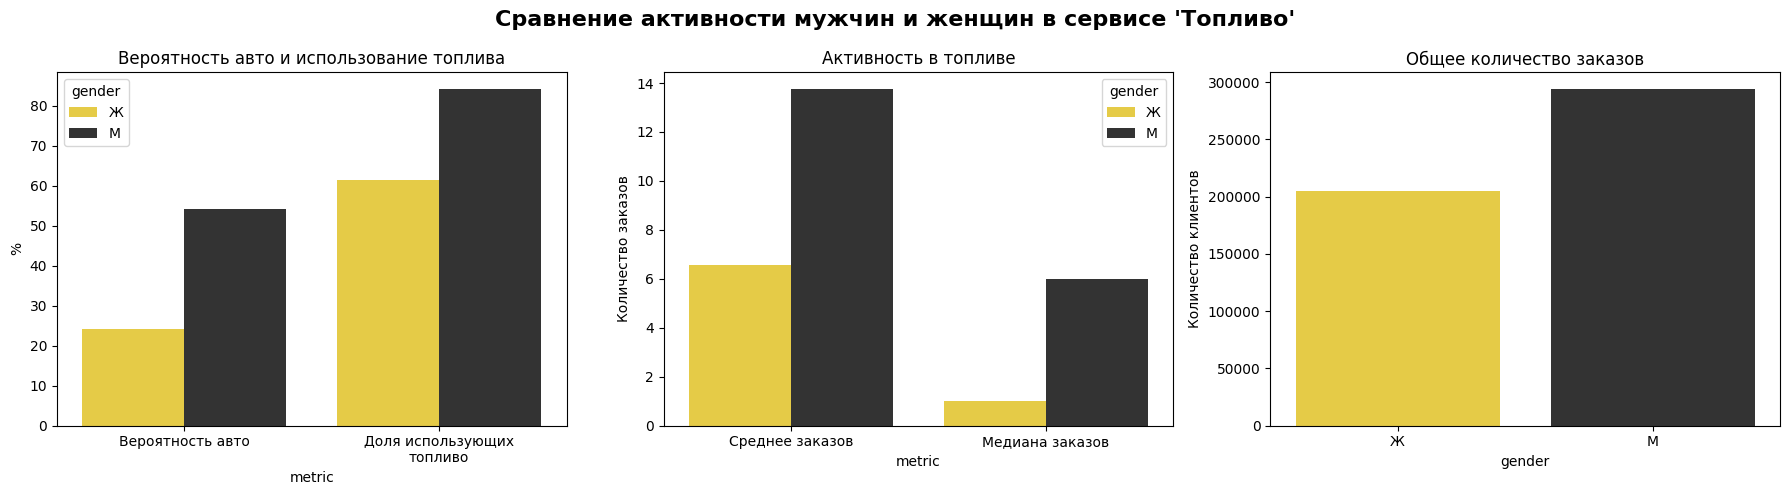

,mean,median,count
gender_cd,,,
F,6.557599,1.0,204656
M,13.751272,6.0,293936


In [ ]:
fuel_by_gender = gorod_clients.groupby('gender_cd')['fuel_n_orders'].agg(['mean', 'median', 'count'])
auto_by_gender = gorod_clients.groupby('gender_cd')['personal_auto_score'].mean() * 100
gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0
fuel_used_by_gender =  gorod_clients.groupby('gender_cd')['used_fuel'].mean() * 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

plot1_data = pd.DataFrame({
    'metric': ['Вероятность авто', 'Доля использующих\nтопливо'] * 2,
    'value': [auto_by_gender['F'], fuel_used_by_gender['F'],
              auto_by_gender['M'], fuel_used_by_gender['M']],
    'gender': ['Ж', 'Ж', 'М', 'М']
})
sns.barplot(data=plot1_data, x='metric', y='value', hue='gender', palette=['#FFDD2D', '#333333'], ax=ax1)
ax1.set_title('Вероятность авто и использование топлива')
ax1.set_ylabel('%')

plot2_data = pd.DataFrame({
    'metric': ['Среднее заказов', 'Медиана заказов'] * 2,
    'value': [fuel_by_gender.loc['F', 'mean'], fuel_by_gender.loc['F', 'median'],
              fuel_by_gender.loc['M', 'mean'], fuel_by_gender.loc['M', 'median']],
    'gender': ['Ж', 'Ж', 'М', 'М']
})
sns.barplot(data=plot2_data, x='metric', y='value', hue='gender', palette=['#FFDD2D', '#333333'], ax=ax2)
ax2.set_title('Активность в топливе')
ax2.set_ylabel('Количество заказов')

plot3_data = pd.DataFrame({
    'gender': ['Ж', 'М'],
    'value': [fuel_by_gender.loc['F', 'count'], fuel_by_gender.loc['M', 'count']]
})
sns.barplot(data=plot3_data, x='gender', y='value', hue= 'gender', palette=['#FFDD2D', '#333333'], ax=ax3)
ax3.set_title('Общее количество заказов')
ax3.set_ylabel('Количество клиентов')

plt.suptitle("Сравнение активности мужчин и женщин в сервисе 'Топливо'",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
fuel_by_gender

Мужчины действительно активнее пользуются Топливом, чем женщины. Возможно, этим и обьясняется большая конверсия - некоторые мужчины начинают пользоваться городом только ради топлива. В таком случае, стоит привлечь их к использованию других сервисов. Проверим эту гипотезу

/tmp/ipython-input-3960740318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['services_used'] = ((gorod_clients['fuel_n_orders'] > 0).astype(int) +
/tmp/ipython-input-3960740318.py:16: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=multi_service_analysis.index, y=multi_service_analysis.values,
/tmp/ipython-input-3960740318.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Мужчины', 'Женщины'])


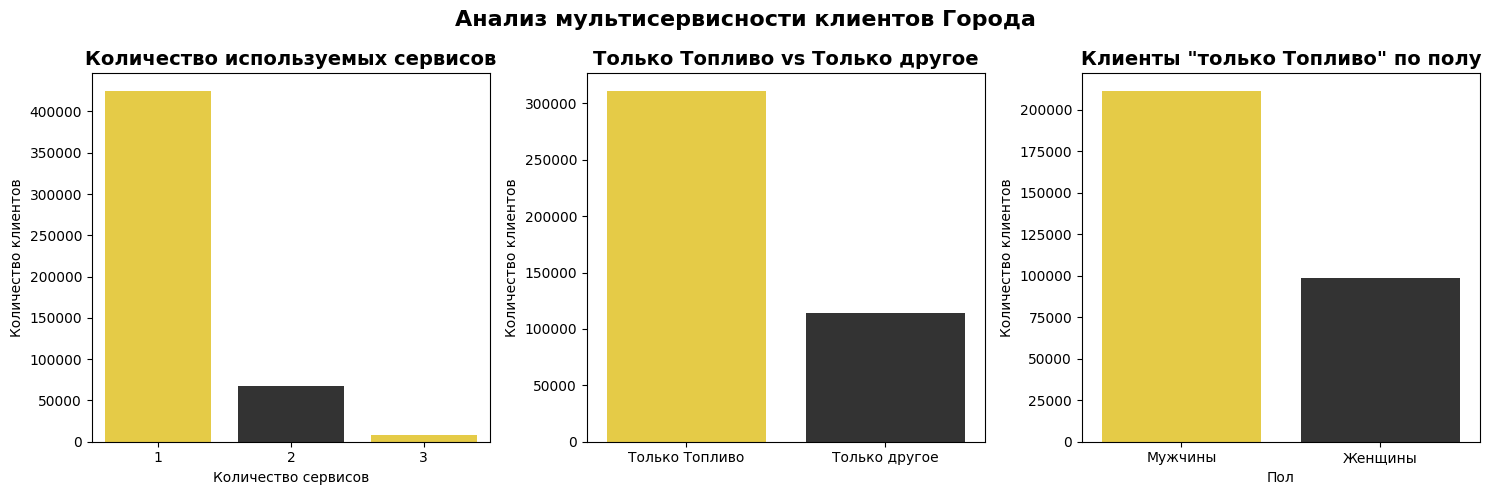

/tmp/ipython-input-3960740318.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0
/tmp/ipython-input-3960740318.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['used_supermarket'] = gorod_clients['supermarket_n_orders'] > 0
/tmp/ipython-input-3960740318.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in


Всего пользователей Топлива: 373,971
Из них используют Продукты: 36,034 (9.6%)
Из них используют Афишу: 34,958 (9.3%)
Из них используют другие сервисы: 62,896 (16.8%)


In [ ]:
gorod_clients['services_used'] = ((gorod_clients['fuel_n_orders'] > 0).astype(int) +
  (gorod_clients['supermarket_n_orders'] > 0).astype(int) + (gorod_clients['afisha_n_orders'] > 0).astype(int))

multi_service_analysis = gorod_clients['services_used'].value_counts()

fuel_clients = gorod_clients[(gorod_clients['fuel_n_orders'] > 0) & (gorod_clients['supermarket_n_orders'] == 0) &
    (gorod_clients['afisha_n_orders'] == 0)]

fuel_proportion = [len(fuel_clients), len(gorod_clients[gorod_clients['services_used'] == 1]) - len(fuel_clients)]
labels = ['Только Топливо', 'Только другое']

fuel_clients_by_gender = fuel_clients['gender_cd'].value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=multi_service_analysis.index, y=multi_service_analysis.values,hue=multi_service_analysis.index,
            palette=['#FFDD2D', '#333333'],legend=False, ax=ax1)
ax1.set_title('Количество используемых сервисов', fontweight='bold', fontsize=14)
ax1.set_xlabel('Количество сервисов')
ax1.set_ylabel('Количество клиентов')

sns.barplot(x=labels, y=fuel_proportion, hue=labels, palette=['#FFDD2D', '#333333'], legend=False, ax=ax2)
ax2.set_title('Только Топливо vs Только другое', fontweight='bold', fontsize=14)
ax2.set_ylabel('Количество клиентов')

sns.barplot(x=fuel_clients_by_gender.index, y=fuel_clients_by_gender.values, hue=fuel_clients_by_gender.index,
            palette=['#FFDD2D', '#333333'], legend=False, ax=ax3)
ax3.set_title('Клиенты "только Топливо" по полу', fontweight='bold', fontsize=14)
ax3.set_xlabel('Пол')
ax3.set_ylabel('Количество клиентов')
ax3.set_xticklabels(['Мужчины', 'Женщины'])

plt.suptitle('Анализ мультисервисности клиентов Города', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0
gorod_clients['used_supermarket'] = gorod_clients['supermarket_n_orders'] > 0
gorod_clients['used_afisha'] = gorod_clients['afisha_n_orders'] > 0

fuel_users = gorod_clients[gorod_clients['used_fuel']]
total_fuel_users = len(fuel_users)

fuel_with_supermarket = fuel_users[fuel_users['used_supermarket']]
fuel_with_afisha = fuel_users[fuel_users['used_afisha']]
fuel_with_any_other = fuel_users[fuel_users['services_used'] >= 2]

print(f"\nВсего пользователей Топлива: {total_fuel_users:,}")
print(f"Из них используют Продукты: {len(fuel_with_supermarket):,} ({len(fuel_with_supermarket)/total_fuel_users*100:.1f}%)")
print(f"Из них используют Афишу: {len(fuel_with_afisha):,} ({len(fuel_with_afisha)/total_fuel_users*100:.1f}%)")
print(f"Из них используют другие сервисы: {len(fuel_with_any_other):,} ({len(fuel_with_any_other)/total_fuel_users*100:.1f}%)")


Действительно, большинство наших клиентов используют только 1 сервис, причём в большинстве случаев, это Топливо. Имеет смысл вовлекать не только новых клиентов в Город, но и увеличивать конверсию из Топлива в другие сервисы (сейчас 16,8%) с помощью персональных предложений в этой вкладке, прекрёстной программы лояльности и прочими методами

Исследуем потенциал для кросс-продаж

In [ ]:
fuel_users_with_supermarket_spend = fuel_users[fuel_users['supermarkety_gmv'] > fuel_users['supermarkety_gmv'].median()]
potential_supermsrket_users = fuel_users_with_supermarket_spend[fuel_users_with_supermarket_spend['used_supermarket'] == 0]

print(f"Клиенты Топлива с высокими тратами в супермаркетах: {len(fuel_users_with_supermarket_spend)}")
print(f"Из них еще не используют Супермаркет: {len(potential_supermsrket_users)}")

fuel_users_with_afisha_spend = fuel_users[(fuel_users['razvlechenija_gmv'] > 0) | (fuel_users['kino_gmv'] > 0)]
potential_afisha_users = fuel_users_with_afisha_spend[fuel_users_with_afisha_spend['used_afisha'] == 0]

print(f"Клиенты Топлива с тратами на развлечения: {len(fuel_users_with_afisha_spend)}")
print(f"Из них еще не используют Афишу: {len(potential_afisha_users)}")

Клиенты Топлива с высокими тратами в супермаркетах: 184211
Из них еще не используют Супермаркет: 161473
Клиенты Топлива с тратами на развлечения: 192131
Из них еще не используют Афишу: 164104


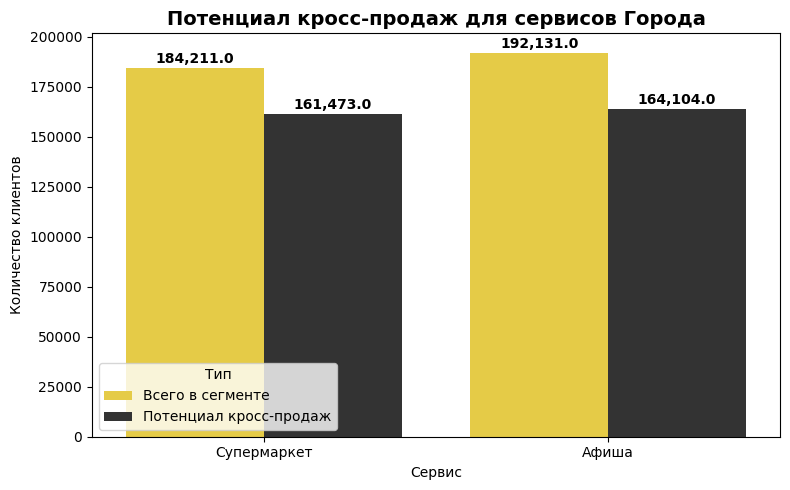

In [ ]:
plot_data = pd.DataFrame({
    'Сервис': ['Супермаркет', 'Афиша', 'Супермаркет', 'Афиша'],
    'Тип': ['Всего в сегменте', 'Всего в сегменте', 'Потенциал кросс-продаж', 'Потенциал кросс-продаж'],
    'Клиенты': [len(fuel_users_with_supermarket_spend), len(fuel_users_with_afisha_spend),
                len(potential_supermsrket_users), len(potential_afisha_users)]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_data, x='Сервис', y='Клиенты', hue='Тип', palette=['#FFDD2D', '#333333'])

plt.title('Потенциал кросс-продаж для сервисов Города', fontweight='bold', fontsize=14)
plt.ylabel('Количество клиентов')

for i, container in enumerate(plt.gca().containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Посмотрим на LTV

<>:12: SyntaxWarning: invalid escape sequence '\L'
<>:12: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-815381106.py:12: SyntaxWarning: invalid escape sequence '\L'
  print(f"\LTV АНАЛИЗ:")
/tmp/ipython-input-815381106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0
/tmp/ipython-input-815381106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gorod_clients['used_supermarket'] = gorod_clients['supermarket_n_orders'] > 0
/

\LTV АНАЛИЗ:
Клиенты без Топлива: 9092
Клиенты с Топливом: 24347

ПОТЕНЦИАЛ КРОСС-ПРОДАЖ:
LTV (только Топливо): 22794
LTV (Топливо + другие): 35407
Uplift: +12613 у.е. (55%)
Потенциальный доход (10% конверсия): 392,360,047


/tmp/ipython-input-815381106.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_data, x='Сегмент', y='Клиенты', ax=ax1, palette=['#FFDD2D', '#333333'])
/tmp/ipython-input-815381106.py:36: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=dist_data, x='Сегмент', y='Клиенты', ax=ax1, palette=['#FFDD2D', '#333333'])
/tmp/ipython-input-815381106.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ltv_data, x='Сегмент', y='LTV', ax=ax2, palette=['#FFDD2D', '#333333'])


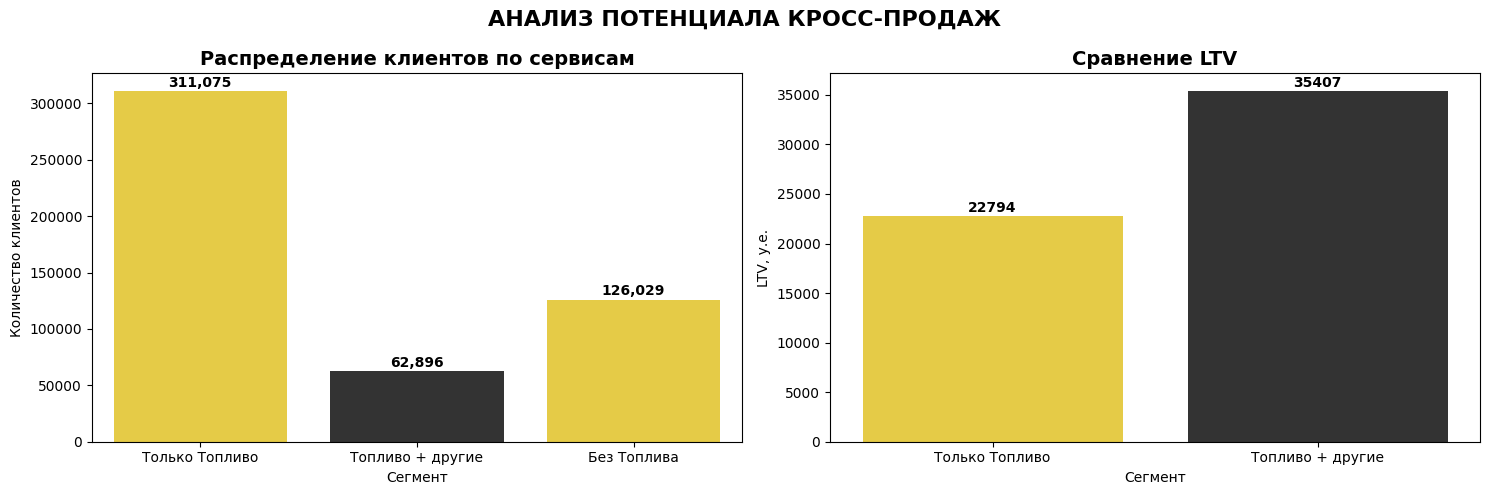

In [161]:
gorod_clients['used_fuel'] = gorod_clients['fuel_n_orders'] > 0
gorod_clients['used_supermarket'] = gorod_clients['supermarket_n_orders'] > 0
gorod_clients['used_afisha'] = gorod_clients['afisha_n_orders'] > 0
gorod_clients['services_used'] = ((gorod_clients['fuel_n_orders'] > 0).astype(int) +
  (gorod_clients['supermarket_n_orders'] > 0).astype(int) + (gorod_clients['afisha_n_orders'] > 0).astype(int))

gorod_clients['total_gorod_gmv'] = gorod_clients[['fuel_gmv', 'supermarket_gmv', 'afisha_gmv']].sum(axis=1)

ltv_segments = gorod_clients.groupby(gorod_clients['fuel_n_orders'] > 0).agg({
    'total_gorod_gmv': 'mean', 'fuel_n_orders': 'count'
})
print(f"\LTV АНАЛИЗ:")
print(f"Клиенты без Топлива: {ltv_segments.loc[False, 'total_gorod_gmv']:.0f}")
print(f"Клиенты с Топливом: {ltv_segments.loc[True, 'total_gorod_gmv']:.0f}")

fuel_only_ltv = fuel_users['fuel_gmv'].mean()
multi_service_ltv = gorod_clients[(gorod_clients['fuel_n_orders'] > 0) &
 (gorod_clients['services_used'] >= 2)]['total_gorod_gmv'].mean()

ltv_uplift = multi_service_ltv - fuel_only_ltv
potential_revenue = len(fuel_clients) * ltv_uplift * 0.1

print(f"\nПОТЕНЦИАЛ КРОСС-ПРОДАЖ:")
print(f"LTV (только Топливо): {fuel_only_ltv:.0f}")
print(f"LTV (Топливо + другие): {multi_service_ltv:.0f}")
print(f"Uplift: +{ltv_uplift:.0f} у.е. ({ltv_uplift/fuel_only_ltv*100:.0f}%)")
print(f"Потенциальный доход (10% конверсия): {potential_revenue:,.0f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

dist_data = pd.DataFrame({
    'Сегмент': ['Только Топливо', 'Топливо + другие', 'Без Топлива'],
    'Клиенты': [len(fuel_clients), len(fuel_users) - len(fuel_clients), len(gorod_clients) - len(fuel_users)]
})

sns.barplot(data=dist_data, x='Сегмент', y='Клиенты', ax=ax1, palette=['#FFDD2D', '#333333'])
ax1.set_title('Распределение клиентов по сервисам', fontweight='bold', fontsize=14)
ax1.set_ylabel('Количество клиентов')
ax1.tick_params(axis='x')

for i, v in enumerate(dist_data['Клиенты']):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

ltv_data = pd.DataFrame({
    'Сегмент': ['Только Топливо', 'Топливо + другие'],
    'LTV': [fuel_only_ltv, multi_service_ltv]
})

sns.barplot(data=ltv_data, x='Сегмент', y='LTV', ax=ax2, palette=['#FFDD2D', '#333333'])
ax2.set_title('Сравнение LTV', fontweight='bold', fontsize=14)
ax2.set_ylabel('LTV, у.е.')
ax2.tick_params(axis='x')

for i, v in enumerate(ltv_data['LTV']):
    ax2.text(i, v + 100, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('АНАЛИЗ ПОТЕНЦИАЛА КРОСС-ПРОДАЖ', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Видим большой потенциал кросс-продаж. Можно будет запустить A/B тесты. Но вернёмся к разведывательному анализу и исследуем влияние региона на конверсию

In [ ]:
region_dict = {
    1: 'Республика Адыгея',
    2: 'Республика Башкортостан',
    3: 'Республика Бурятия',
    4: 'Республика Алтай',
    5: 'Республика Дагестан',
    6: 'Республика Ингушетия',
    7: 'Кабардино-Балкарская Республика',
    8: 'Республика Калмыкия',
    9: 'Карачаево-Черкесская Республика',
    10: 'Республика Карелия',
    11: 'Республика Коми',
    12: 'Республика Крым',
    13: 'Республика Марий Эл',
    14: 'Республика Мордовия',
    15: 'Республика Саха (Якутия)',
    16: 'Республика Татарстан',
    17: 'Республика Тыва',
    18: 'Удмуртская Республика',
    19: 'Республика Хакасия',
    20: 'Чеченская Республика',
    21: 'Чувашская Республика',
    22: 'Алтайский край',
    23: 'Краснодарский край',
    24: 'Красноярский край',
    25: 'Приморский край',
    26: 'Ставропольский край',
    27: 'Хабаровский край',
    28: 'Амурская область',
    29: 'Архангельская область',
    30: 'Астраханская область',
    31: 'Белгородская область',
    32: 'Брянская область',
    33: 'Владимирская область',
    34: 'Волгоградская область',
    35: 'Вологодская область',
    36: 'Воронежская область',
    37: 'Ивановская область',
    38: 'Иркутская область',
    39: 'Калининградская область',
    40: 'Калужская область',
    41: 'Камчатский край',
    42: 'Кемеровская область',
    43: 'Кировская область',
    44: 'Костромская область',
    45: 'Курганская область',
    46: 'Курская область',
    47: 'Ленинградская область',
    48: 'Липецкая область',
    49: 'Магаданская область',
    50: 'Московская область',
    51: 'Мурманская область',
    52: 'Нижегородская область',
    53: 'Новгородская область',
    54: 'Новосибирская область',
    55: 'Омская область',
    56: 'Оренбургская область',
    57: 'Орловская область',
    58: 'Пензенская область',
    59: 'Пермский край',
    60: 'Псковская область',
    61: 'Ростовская область',
    62: 'Рязанская область',
    63: 'Самарская область',
    64: 'Саратовская область',
    65: 'Сахалинская область',
    66: 'Свердловская область',
    67: 'Смоленская область',
    68: 'Тамбовская область',
    69: 'Тверская область',
    70: 'Томская область',
    71: 'Тульская область',
    72: 'Тюменская область',
    73: 'Ульяновская область',
    74: 'Челябинская область',
    75: 'Забайкальский край',
    76: 'Ярославская область',
    77: 'Москва',
    78: 'Санкт-Петербург',
    79: 'Еврейская автономная область',
    82: 'Республика Крым',
    83: 'Ненецкий автономный округ',
    86: 'Ханты-Мансийский автономный округ — Югра',
    87: 'Чукотский автономный округ',
    89: 'Ямало-Ненецкий автономный округ',
    90: 'Запорожская область',
    91: 'Республика Крым',
    92: 'Севастополь',
    93: 'Краснодарский край',
    94: 'Байконур',
    95: 'Чеченская Республика',
    96: 'Свердловская область',
    97: 'Москва',
    98: 'Санкт-Петербург',
    99: 'Москва',
    0: 'Не указан'
}
df['region_name'] = df['region'].map(region_dict)
df[df['gorod_client_flg'] == 1]['region_name'].value_counts(normalize = True) * 100

,proportion
region_name,
Москва,13.940581
Московская область,8.462181
Санкт-Петербург,7.337922
Республика Татарстан,4.717453
Свердловская область,4.433761
...,...
Республика Ингушетия,0.010040
Чукотский автономный округ,0.007238
Еврейская автономная область,0.005137


Больше всего пользователей в густонаселённых регионах, что логично. Посмотрим на конверсию

In [ ]:
region_conversion = df.groupby('region_name')['gorod_client_flg'].mean().sort_values(ascending=False) * 100
region_conversion


,gorod_client_flg
region_name,
Не указан,100.000000
Нижегородская область,62.007668
Республика Татарстан,61.135318
Калининградская область,61.034030
Санкт-Петербург,60.171552
...,...
Сахалинская область,15.340909
Амурская область,10.319105
Чеченская Республика,10.011334


Посмотрим подробнее на лидеров

In [169]:
top_regions = region_conversion[region_conversion.index != 'Не указан'].head(10)
top_regions = pd.DataFrame({'ТОП 10 РЕГИОНОВ С ЛУЧШЕЙ КОНВЕРСИЕЙ': top_regions.values}, index=top_regions.index)

top_regions

,ТОП 10 РЕГИОНОВ С ЛУЧШЕЙ КОНВЕРСИЕЙ
region_name,
Нижегородская область,62.007668
Республика Татарстан,61.135318
Калининградская область,61.034030
Санкт-Петербург,60.171552
Свердловская область,59.653807
Кировская область,58.977720
Чувашская Республика,58.565848
Удмуртская Республика,58.298011
Ивановская область,58.086993


Это регионы с плотным населением, высоким уровнем инфраструктуры и цифровизации. Возможно, в этих регионах люди активнее пользуются IT-технологиями, включая Город. Проверим

/tmp/ipython-input-1418456463.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Остальные', 'Топ-10'], fontsize=11)
/tmp/ipython-input-1418456463.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Остальные', 'Топ-10'], fontsize=11)
/tmp/ipython-input-1418456463.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Остальные', 'Топ-10'], fontsize=11)


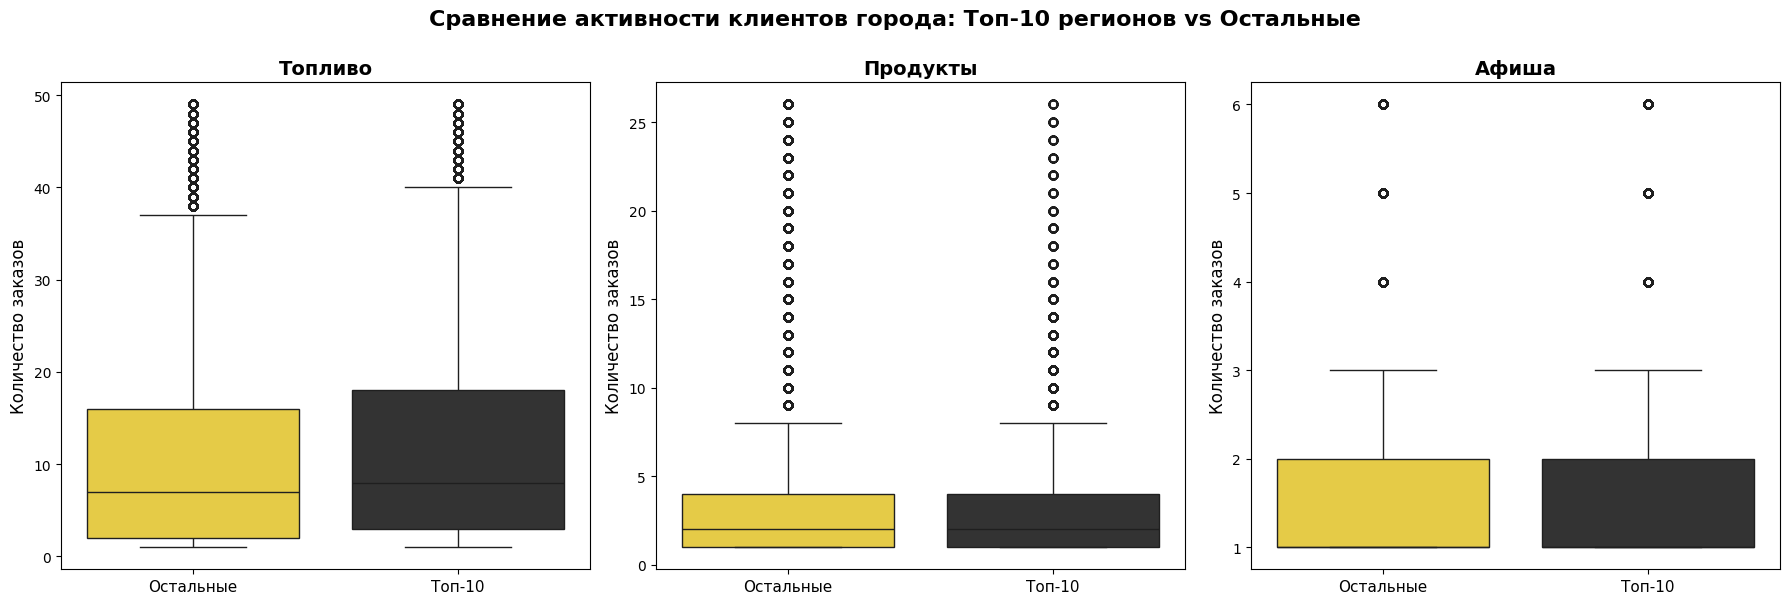

In [ ]:
df_original = pd.read_csv('city_clients.csv')

date_columns = ['fuel_first_order_date', 'supermarket_first_order_date', 'afisha_first_order_date']
for col in date_columns:
    df_original[col] = pd.to_datetime(df_original[col], errors='coerce')

df_original['region_name'] = df_original['region'].map(region_dict)
df_original['is_top_region'] = df_original['region_name'].isin(top_regions.index.tolist())
df_original['is_top_region'] = df_original['is_top_region'].fillna(False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    service = services[i]
    title = titles[i]

    plot_data = df_original[(df_original['gorod_client_flg'] == 1) &
     (df_original[service].notna()) & (df_original[service] > 0)]

    q95 = plot_data[service].quantile(0.95)
    plot_data_clean = plot_data[plot_data[service] <= q95]

    sns.boxplot(data=plot_data_clean, x='is_top_region', y=service, hue='is_top_region',
                ax=axes[i], palette=['#FFDD2D', '#333333'], legend=False)
    axes[i].set_title(title, fontweight='bold', fontsize=14)
    axes[i].set_ylabel('Количество заказов', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(['Остальные', 'Топ-10'], fontsize=11)

plt.suptitle('Сравнение активности клиентов города: Топ-10 регионов vs Остальные',
             fontsize=16, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

Нет, хоть в этих регионах и высокая конверсия, но те, кто начал пользоваться, ведут себя одинаково, независимо от региона. Возможно, конверсия обьясняется агрессивным маркетингом или коллаборациями с местными бизнесами

Посмотрим на портрет среднестатистического пользователя Города для топ10 регионов и остальных

In [125]:
demo_comparison = gorod_clients.groupby('is_top_region')[['age', 'personal_auto_score', 'children_cnt']].mean()

print("\nДемография регионов:")
print(demo_comparison)

top_region_data = gorod_clients[gorod_clients['is_top_region'] == 1]
other_region_data = gorod_clients[gorod_clients['is_top_region'] == 0]
metrics = ['age', 'personal_auto_score', 'children_cnt']

for metric in metrics:
  top_values = top_region_data[metric].dropna()
  other_values = other_region_data[metric].dropna()
  t_stat, p_value = sp.stats.ttest_ind(top_values, other_values, nan_policy='omit', equal_var=False)
  print(p_value)


Демография регионов:
                     age  personal_auto_score  children_cnt
is_top_region                                              
False          36.343285             0.413015      0.085575
True           35.965662             0.439913      0.097939
7.728413050722158e-25
3.703247652966104e-86
8.896537660830594e-16


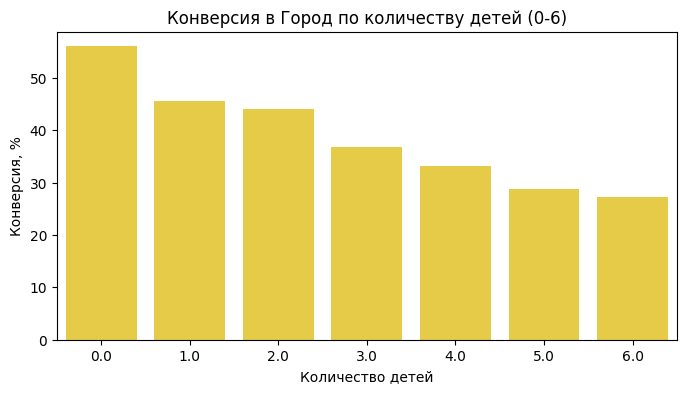

In [172]:
children_conversion = df.groupby('children_cnt')['gorod_client_flg'].mean() * 100
children_0_to_6 = children_conversion[children_conversion.index <= 6]

plt.figure(figsize=(8, 4))
sns.barplot(x=children_0_to_6.index, y=children_0_to_6.values, color='#FFDD2D')
plt.title('Конверсия в Город по количеству детей (0-6)')
plt.xlabel('Количество детей')
plt.ylabel('Конверсия, %')
plt.show()

Чем больше детей, тем меньше вероятность, что человек - клиент Города. Вероятно, это связанно с тем, что молодые люди чаще становятся клиентами города, а много детей, в основном, уже у более возрастных пар

Изучим зависимость конверсии от должности

In [171]:
job_counts = df['job_title'].value_counts()
significant_jobs = job_counts[job_counts >= 50].index
relevant_jobs = df[df['job_title'].isin(significant_jobs)]
job_conversion = relevant_jobs.groupby('job_title')['gorod_client_flg'].mean().sort_values(ascending = False) * 100
job_conversion = pd.DataFrame({'ТОП 10 ДОЛЖНОСТЕЙ С ЛУЧШЕЙ КОНВЕРСИЕЙ': job_conversion.values}, index=job_conversion.index)
job_conversion.head(10)

,ТОП 10 ДОЛЖНОСТЕЙ С ЛУЧШЕЙ КОНВЕРСИЕЙ
job_title,
Представитель банка,95.061728
Ведущий инженер-программист,93.442623
Представитель,92.452830
ПРЕДСТАВИТЕЛЬ,92.196532
Ведущий разработчик,91.803279
представитель,88.235294
Системный аналитик,87.500000
Старший разработчик,87.500000
Инженер-конструктор,85.844749


In [175]:
job_conversion_worse = relevant_jobs.groupby('job_title')['gorod_client_flg'].mean().sort_values() * 100
job_conversion_worse = pd.DataFrame({'ТОП 10 ДОЛЖНОСТЕЙ С ХУДШЕЙ КОНВЕРСИЕЙ': job_conversion_worse.values}, index=job_conversion_worse.index)
job_conversion_worse.head(10)

,ТОП 10 ДОЛЖНОСТЕЙ С ХУДШЕЙ КОНВЕРСИЕЙ
job_title,
Продовец,9.090909
санитарка,10.144928
Горничная,15.492958
Уборщица,15.879828
уборщица,16.153846
Укладчик-упаковщик,17.241379
Упаковщица,17.948718
Пекарь,18.238994
швея,18.292683


Лучшая конверсия наблюдается у высокообразованных, финанансово грамотныхных людей из банковской или IT сферы. Можно сфокусироваться на них, создать профессионализированные офферы.

Худшая конверсия у рабочих специальностей и обслуживающего персонала. Имеет смысл провести образовательные кампании о преимуществах сервиса или заключать партнёрства с работодателями.